![](cats-vs-dogs.jpg)

Dieses Tutorial zeigt, wie man mittels eines Neuronalen Netzwerks / Deep Learning einen Bild-Klassifizierer baut, der Katzenbilder von Hundebildern unterscheidet.

Die Grundlagen zu diesem Workshop kommen aus dem Deep Learning MOOC [fast.ai](http://fast.ai) (Version 1) von Jeremy Howard.

## Inhalt

1. [Einstieg](#Einstieg) - Worum geht es hier? Was ist Deep Learning?
1. [Vorbereitung der Daten](#Vorbereitung-der-Daten) - Welche Daten verarbeiten wir?
1. [Setup](#Setup) - Initialisierung der notwendigen Frameworks
1. [Das VGG16 Modell](#Das-VGG16-Modell) - Laden des Modells
1. [Finetuning & Training](#Finetuning-und-Training) - Training des Modells mit unseren Daten
1. [Vorhersage](#Vorhersage) - Das trainierte Modell anwenden, um eine Vorhersage zu treffen
1. [Beurteilung der Qualität](#Beurteilung-der-Qualität) - Wir schauen uns an, welche Ergebnisse das Modell liefert
1. [Verbessern der Qualität](#Verbessern-der-Qualität) - Verschiedene Möglichkeiten, die Vorhersagequalität zu verbessern
1. [Exkurs: Wenige Bilder Trainieren, viele Bilder klassifizieren](#Exkurs:-Wenige-Bilder-Trainieren,-viele-Bilder-klassifizieren)


## Einstieg

Einordnung Deep Learning:
![Deep Learning Einordnung](deep-learning-1.png)

Deep Neural Networks sind in der Lage, Characteristiken ("Features") selbstständig aus den Daten zu extrahieren:
![Deep Learning Ansatz](santos-DeepLearning.png)
(Quelle: https://leonardoaraujosantos.gitbooks.io/artificial-inteligence/content/deep_learning.html)

## Vorbereitung der Daten

Die Daten für unsere Aufgabenstellung kommen aus dem ["Cats vs. Dogs"](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition) Wettbewerb der Website Kaggle.

Die Daten des Kaggle Wettbewerbs wurden schon vorbereitet und in der "richtigen" Struktur abgelegt.
Das Verzeichnis `data` enthält die Trainings- und Validierungsdaten aus dem Dataset. Dabei sind die Bilder zu jeder zu erkennenden "Klasse" (Cats & Dogs in unserem Fall) in einem eigenen Unterverzeichnis abgelegt:

In [2]:
DATA_DIR = 'data'

In [3]:
# ! führt einen Shell-Befehl aus...
!tree -d {DATA_DIR}

data
├── results
│   ├── filenames.dat
│   │   ├── data
│   │   └── meta
│   └── predictions.dat
│       ├── data
│       └── meta
├── test
│   └── unknown
├── train
│   ├── cats
│   └── dogs
└── valid
    ├── cats
    └── dogs

15 directories


Im Verzeichnis `results`werden die Ergebnisse unserer Experimente abgelegt. In den Vereichnissen `train` sind die Trainingsdaten drin und in `valid` die Validerungsdaten für das Training. Mal schauen, wie viel das so ist:

In [4]:
!echo -n "Training cats: " && ls {DATA_DIR}/train/cats | wc -w
!echo -n "Training dogs: " && ls {DATA_DIR}/train/dogs | wc -w
!echo -n "Validation cats: " && ls {DATA_DIR}/valid/cats | wc -w
!echo -n "Validation dogs: " && ls {DATA_DIR}/valid/dogs | wc -w

Training cats: 11567
Training dogs: 11433
Validation cats: 933
Validation dogs: 1067


Das Verzeichnis `test` enthält die Bilder, die nicht klassifizert sind (deshalb das Unterverzeichnis `unknown`). Diese wollen wir nach dem Training bestimmen. Mal sehen, wieviele das sind:

In [5]:
!echo -n "Test: " && ls {DATA_DIR}/test/unknown | wc -w

Test: 12500


Damit wir am Code herumprobieren können, ohne gleich lange Laufzeiten aufgrund der vielen Dateien zu erhalten, gibt es noch ein `sample` Dataset, welches gleich aufgebaut ist, aber nur nur einen kleinen Teil der Daten enthält:

In [6]:
SAMPLE_DIR = 'sample'

In [7]:
import shutil, os, random

def copy_random_files(source_dir, target_dir, subdir, n_files):
    source_dir = os.path.join(source_dir, subdir)
    target_dir = os.path.join(target_dir, subdir)
    shutil.rmtree(target_dir,ignore_errors=True)
    os.makedirs(target_dir)
    source_files = random.sample(
        [os.path.join(source_dir,file) for file in os.listdir(source_dir) if file.endswith(".jpg")],n_files)
    for source in source_files:
        shutil.copy(source,target_dir)

copy_random_files("data", "sample", "valid/cats", 25)
copy_random_files("data", "sample", "valid/dogs", 25)
copy_random_files("data", "sample", "train/cats", 200)
copy_random_files("data", "sample", "train/dogs", 200)
copy_random_files("data", "sample", "test/unknown", 25)


In [8]:
!tree -d {SAMPLE_DIR}

sample
├── results
│   ├── filenames.dat
│   │   ├── data
│   │   └── meta
│   └── predictions.dat
│       ├── data
│       └── meta
├── test
│   └── unknown
├── train
│   ├── cats
│   └── dogs
└── valid
    ├── cats
    └── dogs

15 directories


In [9]:
!echo -n "Training cats: " && ls {SAMPLE_DIR}/train/cats | wc -w
!echo -n "Training dogs: " && ls {SAMPLE_DIR}/train/dogs | wc -w
!echo -n "Validation cats: " && ls {SAMPLE_DIR}/valid/cats | wc -w
!echo -n "Validation dogs: " && ls {SAMPLE_DIR}/valid/dogs | wc -w
!echo -n "Test: " && ls {SAMPLE_DIR}/test/unknown | wc -w

Training cats: 200
Training dogs: 200
Validation cats: 25
Validation dogs: 25
Test: 25


## Setup

Diesen Teil immer ausführen. Hier werden notwendige Packete geladen und globale Variablen initialisiert.

In [10]:
%matplotlib inline

import shutil
import os.path
import time

import numpy as np
np.set_printoptions(precision=4, linewidth=100)
import utils
import keras
import sklearn

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


Hier setzen wir den Pfad für die Daten, mit denen wir arbeiten wollen (also `data` oder `sample`):

In [11]:
# path = DATA_DIR
path = SAMPLE_DIR

path = os.path.join(os.path.curdir,path)
print path

train_path = os.path.join(path,"train")
valid_path = os.path.join(path,"valid")
test_path = os.path.join(path,"test")
result_path = os.path.join(path,"results")
if not os.path.exists(result_path):
    os.makedirs(result_path)

print train_path
print valid_path
print test_path
print result_path

./sample
./sample/train
./sample/valid
./sample/test
./sample/results


## Das VGG16 Modell

Wir verwenden Convolutional Neuronal Network (CNN) namens "VGG16". Entwickelt wurde [VGG16 im Jahr 2014](https://arxiv.org/pdf/1409.1556.pdf) von der Vision Geometry Group an der University of Oxford  und mit den Daten des [Imagenet Datasets](http://image-net.org/synset?wnid=n02084071) vortrainiert. Es erkennt 1000 verschiedene Ojekte, d.h. es liefert zu einem Bild 1000 Wahrscheinlichkeitswerte, ob das Bild ein Ding dieser Klasse enthält.

![VGG16](vgg16.png) Quelle: http://www.datalearner.com/paper_note/content/300035

Wir laden ein Python Modul, welches VGG16 in ein nettes, mehr oder weniger objektorientiertes API verpackt. Der Sourcecode dazu steht in der Datei `vgg16.py`. Der Code stammt - wie oben erwähnt - von [fast.ai](http://fast.ai).

In [12]:
# Import VGG16 class, and instantiate
import vgg16
vgg = vgg16.Vgg16()

Wir können einen Blick in den Code der Klasse werfen (?? zeigt die Implementierung eines Code-Elements):

In [13]:
??vgg

Wir können auch einen Blick auf die Struktur des Modells werfen. Der folgende Befehl zeigt die Schichten ("Layer"):

In [14]:
vgg.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 3, 224, 224)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 226, 226)   0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 64, 224, 224)  1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 226, 226)  0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [22]:
print "Number of classes: ", len(vgg.classes)
print "First n classes:"
vgg.classes[:10]

Number of classes:  1000
First n classes:


[u'tench',
 u'goldfish',
 u'great_white_shark',
 u'tiger_shark',
 u'hammerhead',
 u'electric_ray',
 u'stingray',
 u'cock',
 u'hen',
 u'ostrich']

Die Frage, was so ein CNN eigentlich "sieht", ist gar nicht so leicht zu beantworten. Es gibt Ansätze, dies zu visualisieren. Die folgende Darstellung zeigt Schematisch das Funktionsprinzip.

![Was ein CNN sieht](salzberg-deep-learning.png)
(Quelle: http://genome.fieldofscience.com/2017/12/no-google-didnt-just-create-ai-that.html)

Das CNN lernt, einfache Muster aus dem Bild zu extrahieren und diese zu immer komplexen Features zu kombinieren. Dazu extrahiert es wichtige Bildeigenschaften mit vielen 3x3 großen "Kernel".Das Prinzip der Kernels ist hier erläutert: http://setosa.io/ev/image-kernels. 

Das Netz selbst besteht aus hintereinandergeschalteten Convolution-Schichten, die immer abstraktare Features extrahieren. Die Werte der Kernel sind Gewichte, die beim Training zielgerichtet angepasst werden. 

## Finetuning und Training

In diesem Schritt passen wir das Modell so an, dass es statt der 1000 Klassen nur noch die uns hier interssierenden 2 Klassen vorhersagt: Cats & Dogs.

Dazu benötigen wir Finetuning & Training.

![Training](training.png)

Wir laden die Trainings- und Validierungsdaten als "Batches". Ein Batch liefert immer die nächsten _n_ Datensätze (`batch_size`) inklusive der Kategorie. Beim Training wird Batch für Batch über die gesamte Menge der Trainings- und Validierungsdaten iteriert. `batch_size` kann man so groß machen wie möglich aber die BeBeschränkung ist das verfügbare Memory der GPU. 64 ist eine gute Empfehlung für die Obergrenze, eventuell muss man weniger angeben.

`vgg.get_batches()` erwartet, dass die Daten in Unterverzeichnissen je Kategorie abgelegt sind. Genau das ist bei uns der Fall, wie wir oben gesehen haben (Verzeichnisse "cats" und "dogs").

In [14]:
batch_size=64

train_batches = vgg.get_batches(train_path, batch_size=batch_size)
validation_batches = vgg.get_batches(valid_path, batch_size=batch_size*2)

Found 400 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


Wie wir auch sehen, hat der Befehl automatisch erkannt, wie viele Klassen in unseren Trainings-/Validierungsdaten enthalten sind: `2 classes` (cats & cogs).

Dann wird das VGG16 Modell an unsere Aufgabe ("cat or dog" Klassifizierung) angepasst mit `vgg.finetune()`. Dies ändert die Architektur des Netzes: Der letzte Layer wird verworfen und durch einen neuen Layer erstetzt, welcher nur noch 2 Outputs hat (statt wie bisher 1000): Cats & Dogs!

In [15]:
vgg.finetune(train_batches)

Wir können uns anschauen, was die Methode `finetune` macht:

In [16]:
??vgg.finetune

Der eigentliche Austausch des letzten Layers erfolgt in der Methode `vgg.ft()`. Die Gewichte des neuen Layers sind zunächst mit Zufallswerten initialisiert worden, d.h. sie müssen noch trainiert werden. Die anderen Layer lassen wir, wie sie sind (`layer.trainable = False`).

In [17]:
??vgg.ft

Jetzt trainieren wir das Modell mit den Daten über `vgg.fit()`. Dabei wird in Wahrheit nur noch der letze (modifizierte) Layer des angepassten VGG16 Modells trainiert.

In [18]:
%%time
# Learning rate:
vgg.model.optimizer.lr = 0.01

vgg.fit(train_batches, validation_batches, nb_epoch=1)

Epoch 1/1
400/400 [==============================] - 14s - loss: 0.4625 - acc: 0.9025 - val_loss: 0.3459 - val_acc: 0.9400
CPU times: user 26.2 s, sys: 7.04 s, total: 33.3 s
Wall time: 22.2 s


Die angepassten Gewichte des Modells schreiben wir in eine Datei, so dass wir sie später wieder laden können und so nicht jedesmal das Training wiederholen müssen.

In [19]:
weights_filename = os.path.join(result_path,'finetune1.h5')
print 'saving weights to ' + weights_filename
vgg.model.save_weights(weights_filename)

saving weights to ./sample/results/finetune1.h5


## Vorhersage

![Prediction](prediction.png)

Nun wenden wir das anpepasste Modell an und klassifizieren wirdie Bilder, die im Unterverzeichnis 'test' abgelegt sind. Anders ausgedrückt: Wir sagen für eine Menge Daten (= ein Bild) vorher, mit jeweils welcher Wahrscheinlichkeit diese Daten eine Katze bzw. ein Hund ist. Die Ergebnisse speichern wir wieder in Dateien, damit wir später bei Bedarf darauf zugreifen können, ohne das ganze Training wiederholen zu müssen.

In [20]:
# Dateien zum Speichern der Ergebnisse:
predictions_file = os.path.join(result_path,'predictions.dat')
filenames_file = os.path.join(result_path,'filenames.dat')

Prediction durchführen und Ergebnisse speichern:

In [21]:
%%time
test_batches, predictions = vgg.test(test_path,batch_size=batch_size*2)

filenames = test_batches.filenames
utils.save_array(predictions_file, predictions)
utils.save_array(filenames_file, filenames)

Found 25 images belonging to 1 classes.
CPU times: user 4.05 s, sys: 556 ms, total: 4.61 s
Wall time: 3.94 s


### Mal ein paar Ergebnisse anschauen

Zunächst eine kleine Hilfsmethode, um Bilder anzeigen zu können:

In [22]:
from keras.preprocessing import image
def plots_idx(idx, path, filenames, titles=None):
    """Loads and displays images with given titles. The images are given with their index in filenames."""
    utils.plots([image.load_img(os.path.join(path,filenames[i])) for i in idx], titles=titles)

Wir laden die Ergebnisse aus den oben geschriebenen Dateien:

In [23]:
predictions = utils.load_array(predictions_file)
filenames = utils.load_array(filenames_file)

Wir wählen zufällig ein paar Bilder aus und zeigen sie mit der Vorhersage an (`[Wahrscheinlichkeit_Katze, Wahrscheinlichkeit_Hund]`).

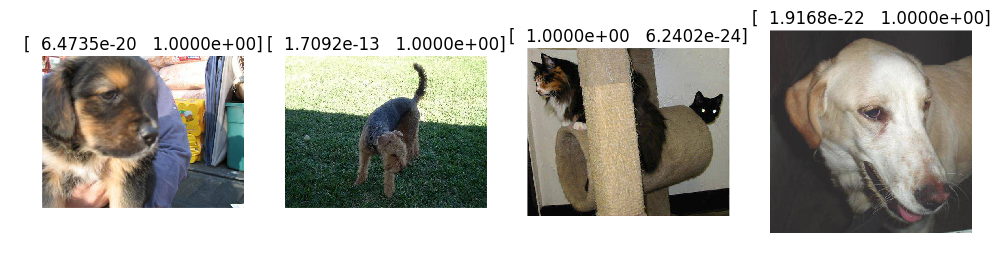

In [35]:
idx = np.random.randint(0, len(test_batches.filenames),4)
idx = np.random.choice(np.arange(len(test_batches.filenames)),4,replace=False)
plots_idx(idx, path=test_path, filenames=test_batches.filenames, titles=predictions[idx])

## Beurteilung der Qualität

Wir wollen uns anschauen, wie gut unser Modell eigentlich vorhersagt. Die Idee dazu ist, dass wir mit dem Modell eine Vorhersage über die bereits klassifizierten Trainingsdaten machen. So kennen wir die "ground truth" zu jedem Bild und können ermitteln, ob die Vorhersage korrekt war.

Den folgenden Block muss man nur ausführen, wenn man das Training oben bereits vorher mal gemacht hatte und die Gewichte in eine Datei geschrieben hat. Dann kann man hier direkt das Modell neu laden mit den (veränderten) Gewichten. Hat man in der gleichen Sitzung das Training schon gemacht, kann man diesen Schritt überspringen.

In [59]:
# Modell nochmal neu initialisieren (falls wir hier wieder beginnen wollen):
import vgg16
vgg = vgg16.Vgg16()
# Nicht vergessen, die letzte Schicht zu verändern (2 statt 1000 Klassen als Output)!
vgg.finetune(train_batches)
# Gewichte laden:
weights_filename = os.path.join(result_path,'finetune1.h5')
vgg.model.load_weights(weights_filename)

Vorhersage mit den Validierungsdaten. So kennnen wir die "ground truth" und können sie mit der Vorhersage des Modells vergleichen.

In [60]:
%%time
# Vorhersage machen:
valid_batches, predictions = vgg.test(valid_path, batch_size=64)

print "First n predictions:"
print predictions[:8]

Found 50 images belonging to 2 classes.
First n predictions:
[[  1.0000e+00   2.1446e-36]
 [  1.0000e+00   2.4570e-26]
 [  1.0000e+00   2.0081e-12]
 [  1.0000e+00   6.0028e-16]
 [  1.0000e+00   1.0539e-12]
 [  1.0000e+00   3.9344e-19]
 [  1.0000e+00   7.4353e-29]
 [  1.0000e+00   7.8939e-14]]
CPU times: user 5.3 s, sys: 936 ms, total: 6.24 s
Wall time: 5.02 s


Wir stutzen uns das Ergebnis zurecht, so dass wir nur noch ein 1-dimeansionales Array mit einer `1` für einen vorhergesagten Hund und einer `0` für eine vorgesagte Katze haben:

In [61]:
our_predictions = predictions[:,1]
print "Probabilities, if it's a dog: ", our_predictions[:8]
our_labels = np.round(our_predictions)
print "Label, if it's a dog: ", our_labels[:8]


Probabilities, if it's a dog:  [  2.1446e-36   2.4570e-26   2.0081e-12   6.0028e-16   1.0539e-12   3.9344e-19   7.4353e-29
   7.8939e-14]
Label, if it's a dog:  [ 0.  0.  0.  0.  0.  0.  0.  0.]


Das ist unsere "ground truth":

In [62]:
expected_labels = valid_batches.classes
filenames = valid_batches.filenames

### Zeige einige korrekte Klassifizierungen

Mit Numpy (`np`) können wir wir den Index aller Bilder ermitteln, bei denen unser vorhergesagtes Label (0 oder 1) mit dem erwarteten Label der "groud truth" übereinstimmt. Davon wählen wir zufällig 4 aus und zeigen sie an:

Found 47 correct labels


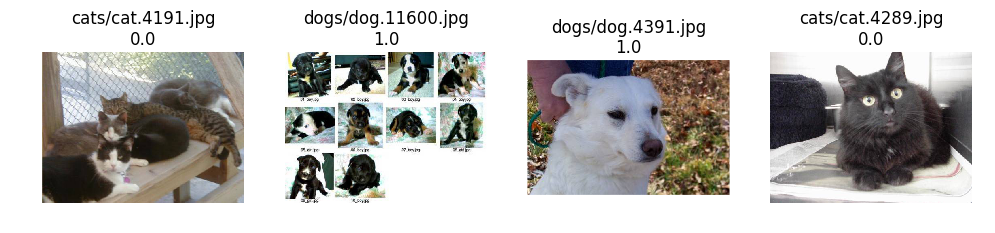

In [64]:
correct = np.where(our_labels==expected_labels)[0]
print "Found {} correct labels".format(len(correct))
idx = np.random.permutation(correct)[:4]
titles = [filenames[i]+'\n'+ str(our_labels[i]) for i in idx]
plots_idx(idx, valid_path, filenames, titles)

### Zeige einige falsche Klassifizierungen

Found 3 incorrect labels.


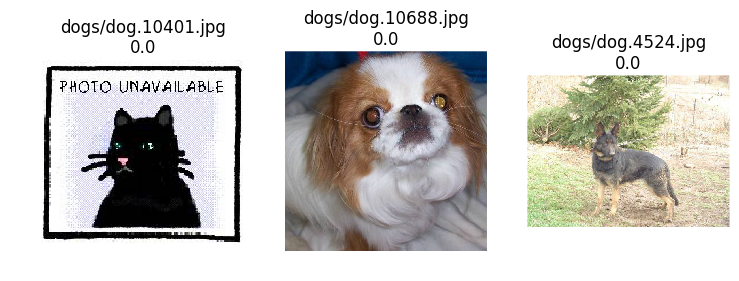

In [79]:
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found {} incorrect labels.".format(len(incorrect))
if len(incorrect)>0:
    idx = np.random.permutation(incorrect)[:4]
    titles = [filenames[i]+'\n'+ str(our_labels[i]) for i in idx]
    plots_idx(idx, valid_path, filenames, titles)

### Zeige einige richtige Klassifizierungen mit großer  Wahrscheinlichkeit

... also die, bei denen das Modell wirklich recht hatte.

Found 22 confident correct dogs labels
Found 25 confident correct cats labels


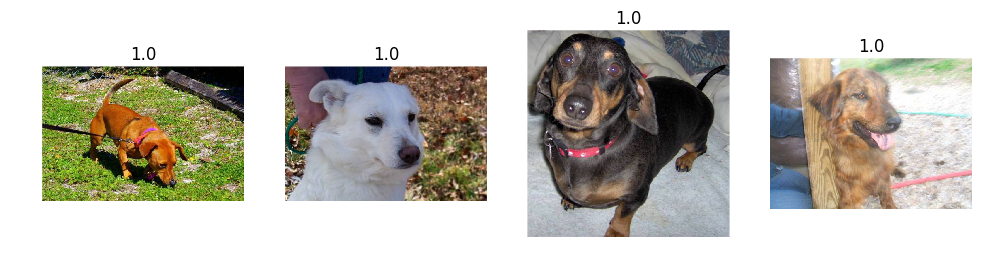

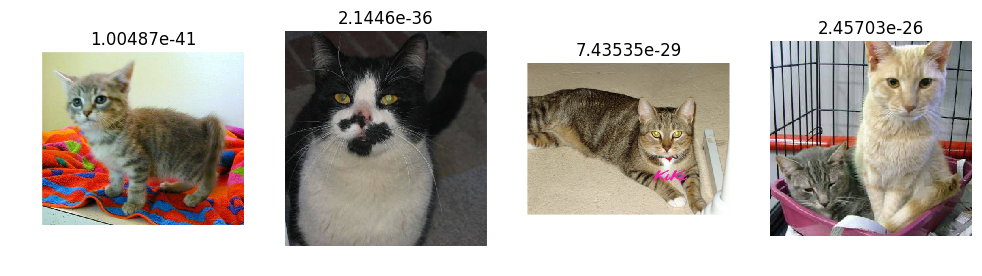

In [68]:
n_view = 4

# The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print "Found {} confident correct dogs labels".format(len(correct_dogs))
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[::-1][:n_view]
plots_idx(correct_dogs[most_correct_dogs], valid_path, filenames, our_predictions[correct_dogs][most_correct_dogs])

# The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print "Found {} confident correct cats labels".format(len(correct_cats))
most_correct_cats = np.argsort(our_predictions[correct_cats])[::][:n_view]
plots_idx(correct_cats[most_correct_cats], valid_path, filenames, our_predictions[correct_cats][most_correct_cats])


### Zeige einige falsche Klassifizierungen mit großer Wahrscheinlichkeit

... also die, bei denen das Modell total daneben lag.

Found 0 confident incorrect dogs labels
Found 3 confident incorrect cats labels


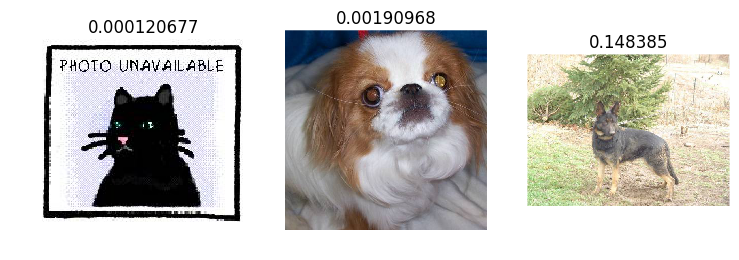

In [69]:
# The images we most confident were dogs, and are actually dogs
confident_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print "Found {} confident incorrect dogs labels".format(len(confident_dogs))
if len(confident_dogs)>0:
    most_confident_dogs = np.argsort(our_predictions[confident_dogs])[::-1][:n_view]
    plots_idx(confident_dogs[most_confident_dogs], valid_path, filenames, our_predictions[confident_dogs][most_confident_dogs])

# The images we most confident were dogs, and are actually dogs
confident_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print "Found {} confident incorrect cats labels".format(len(confident_cats))
if len(confident_cats)>0:
    most_confident_cats = np.argsort(our_predictions[confident_cats])[::][:n_view]
    plots_idx(confident_cats[most_confident_cats], valid_path, filenames, our_predictions[confident_cats][most_confident_cats])


### Ziege die unsichersten Klassifizierungen

... also die, bei denen sich das Modell nicht so sicher war.

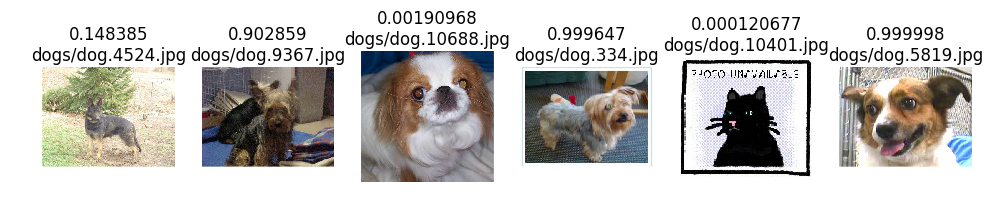

In [71]:
uncertain = np.argsort(np.abs(our_predictions-0.5))
titles = [str(our_predictions[i])+'\n'+filenames[i] for i in uncertain]
plots_idx(uncertain[:6], valid_path, filenames, titles)

### Confusion Matrix

[[25  0]
 [ 3 22]]


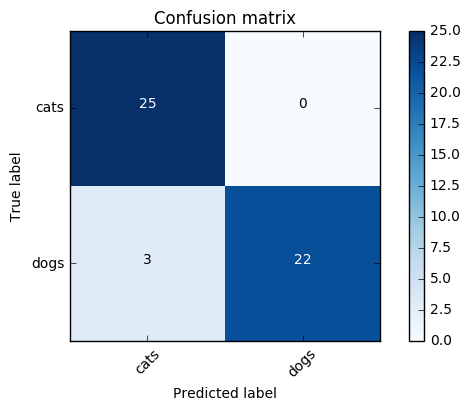

In [72]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(expected_labels,our_labels)
utils.plot_confusion_matrix(cm, valid_batches.class_indices)

## Verbesserung der Qualität

Wollen wir die Qualität unseres Modells weiter verbessern haben wir mehrere Möglichkeiten:
* mehr Trainingsdaten verwenden
* mit den vorhandenen Trainingsdaten mehrmals trainieren
* mehr Layer trainieren
* die Lernrate verändern

Bisher haben wir nur den letzten Layer des Modells neu trainiert und den Rest des Modells nicht angetastet. Wenn wir nun auch die mittleren Layer re-trainieren wollen geht das mit Keras ziemlich einfach...

Zunächst: Modell laden und initalisieren, indem wir die Gewichte aus unserem Training oben laden:

In [90]:
def init_model(batches, weights):
    # Modell nochmal neu initialisieren:
    vgg = vgg16.Vgg16()
    # Nicht vergessen, die letzte Schicht zu verändern (n statt 1000 Klassen als Output)!
    vgg.finetune(batches)
    # Gewichte aus Datei laden:
    weights_filename = os.path.join(result_path, weights)
    vgg.model.load_weights(weights_filename)
    return vgg

In [91]:
vgg2 = init_model(train_batches, 'finetune1.h5')

Nochmal kurz einen Blick auf die Struktur des Modells werfen:

In [92]:
vgg2.model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_8 (Lambda)                (None, 3, 224, 224)   0           lambda_input_8[0][0]             
____________________________________________________________________________________________________
zeropadding2d_92 (ZeroPadding2D) (None, 3, 226, 226)   0           lambda_8[0][0]                   
____________________________________________________________________________________________________
convolution2d_92 (Convolution2D) (None, 64, 224, 224)  0           zeropadding2d_92[0][0]           
____________________________________________________________________________________________________
zeropadding2d_93 (ZeroPadding2D) (None, 64, 226, 226)  0           convolution2d_92[0][0]           
___________________________________________________________________________________________

Achtung: Wir müssen darauf achten, den letzten Layer (den wir oben selbst hinzugefügt haben) vorher über `vgg.fit()` auch trainiert zu haben, da er sonst mit Zufallswerten initialisert ist, welche das Training der Zwischenschichten ziemlich durcheinander bringen würde. Wenn wir die zuvor in einer Datei gespeicherten Gewichte verwenden ist das automatisch der Fall.


### Alle Dense Layer neu trainieren
Der erste Versuch ist, nur die `Dense` Layer am Ende des Modells neu zu trainieren. `Dense` Layer bilden Lineare Funktionen ab, die mit allen Outputs der vorigen Layer verbunden sind.

In [93]:
# Hilfsmethode, um Modell anzupassen (fitting):
def fit_model(model, train_batches, validation_batches, nb_epoch=1):
    model.fit_generator(train_batches, samples_per_epoch=train_batches.N, nb_epoch=nb_epoch, 
                        validation_data=validation_batches, nb_val_samples=validation_batches.N)

In [94]:
# Hole den Index des ersten "dense" layers:
first_dense_idx = [index for index,layer in enumerate(vgg2.model.layers) if type(layer) is keras.layers.core.Dense][0]
print "First dense layer is layer no. " + str(first_dense_idx)
# ...und setze diesen und alle nachfolgenden auf "trainierbar":
for layer in vgg2.model.layers[first_dense_idx:]: layer.trainable=True

First dense layer is layer no. 33


Jetzt trainieren wir _alle_ Layer ab dem ersten "Dense" Layer neu (diesmal mit 3 Durchläufen durch die Trainingsdaten) und speichern die Gewichte wieder:

In [95]:
%%time
keras.backend.set_value(vgg2.model.optimizer.lr, 0.01)

fit_model(vgg2.model, train_batches, validation_batches, 3)

weights_filename = os.path.join(result_path,'finetune2.h5')
vgg2.model.save_weights(weights_filename)

Epoch 1/3
400/400 [==============================] - 14s - loss: 0.2913 - acc: 0.9650 - val_loss: 0.2851 - val_acc: 0.9200
Epoch 2/3
400/400 [==============================] - 13s - loss: 0.1396 - acc: 0.9850 - val_loss: 0.7587 - val_acc: 0.9400
Epoch 3/3
400/400 [==============================] - 13s - loss: 0.2585 - acc: 0.9700 - val_loss: 0.6839 - val_acc: 0.9400
CPU times: user 51.1 s, sys: 20.9 s, total: 1min 11s
Wall time: 54 s


Um das Modell zu beurteilen, ist es sinnvoll, die "Categorical Cross Entropy" zu berechnen und anzuzeigen:

In [96]:
def predict_and_plot_confusion_matrix(vgg, path):
    # Prediction:
    batches, predictions = vgg.test(path, batch_size=64)
    our_predictions = predictions[:,0]
    our_labels = np.round(1-our_predictions)

    # Ground truth:
    expected_labels = batches.classes

    cm = sklearn.metrics.confusion_matrix(expected_labels,our_labels)
    utils.plot_confusion_matrix(cm, batches.class_indices)

Wir machen wieder eine Vorhersage über ein klassifziertes Dataset ("ground truth") und zeigen die Categorcal Cross Entropy an:

Found 50 images belonging to 2 classes.
[[22  3]
 [ 0 25]]


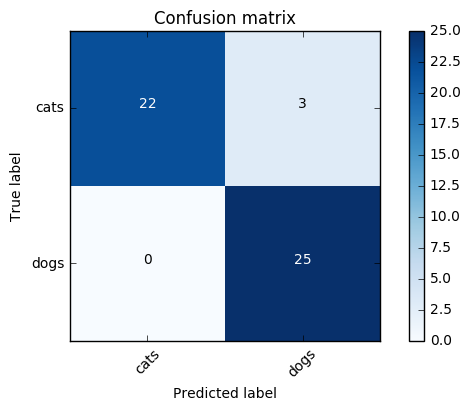

In [97]:
predict_and_plot_confusion_matrix(vgg2,valid_path)

### Noch mehr Layer trainieren

Wir können auch versuchen, noch mehr Layer zu trainieren (nicht nur die Dense-Layer am hinteren Ende des Networks). Ausserdem kann man auch mit der Learning Rate experimentieren:

In [98]:
# Modell nochmal neu initialisieren:
vgg3 = init_model(train_batches,'finetune1.h5')

In [99]:
%%time
for layer in vgg3.model.layers[12:]: 
    layer.trainable=True

keras.backend.set_value(vgg3.model.optimizer.lr, 0.001)

fit_model(vgg3.model, train_batches, validation_batches, 4)

model_file = os.path.join(result_path,'finetune3.h5')
vgg3.model.save_weights(model_file)

Epoch 1/4
400/400 [==============================] - 14s - loss: 0.2999 - acc: 0.9550 - val_loss: 0.0471 - val_acc: 0.9800
Epoch 2/4
400/400 [==============================] - 13s - loss: 0.1310 - acc: 0.9775 - val_loss: 0.1884 - val_acc: 0.9800
Epoch 3/4
400/400 [==============================] - 13s - loss: 0.1844 - acc: 0.9725 - val_loss: 0.1359 - val_acc: 0.9800
Epoch 4/4
400/400 [==============================] - 14s - loss: 0.0377 - acc: 0.9875 - val_loss: 0.0378 - val_acc: 0.9800
CPU times: user 1min 7s, sys: 27.8 s, total: 1min 34s
Wall time: 1min 9s


Auch hier berechnen wir wieder eine Confusion Matrix:

Found 50 images belonging to 2 classes.
[[24  1]
 [ 0 25]]


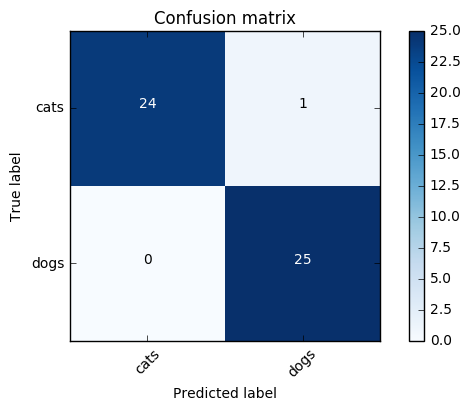

In [100]:
predict_and_plot_confusion_matrix(vgg3,valid_path)

## Exkurs: Wenige Bilder Trainieren, viele Bilder klassifizieren

Wie gut ist unser Modell eigentlich, wenn wir nur mit wenigen Bildern trainieren?

Vorgehensweise:
* Trainieren mit den Bildern des `sample` Datasets (200 Bilder)
* Vorhersagen mit den Bildern des normalen Datasets (23000 Trainingsbilder als Ground Truth)

Da wir hier nicht das ganze Training wiederholen wollen, laden wir die Gewichte aus dem `sample` Pfad - das setzt voraus, dass man den Trainings-Code oben auch mal mit dem `sample` Dataset ausgeführt hat und somit die Datei mit den Gewichten existiert. Im Code unten kann man festlegen, welche Gewichte wir verwenden wollen.

In [101]:
# Modell nochmal neu initialisieren
vgg = vgg16.Vgg16()
# Nicht vergessen, die letzte Schicht zu verändern (2 statt 1000 Klassen als Output)!
vgg.finetune(train_batches)

# Gewichte laden (aus dem 'sample' Pfad!)
weights = 'finetune1.h5'   # Nur der letzte Layer wurde trainiert
#weights = 'finetune2.h5'   # Alle Dense Layer wurden trainiert
#weights = 'finetune3.h5'   # Alle Layer ab Nr. 12 wurden trainiert
weights = os.path.join('sample','results',weights)

print "using weights " + weights
vgg.model.load_weights(weights)

using weights sample/results/finetune1.h5


Found 23000 images belonging to 2 classes.
[[11509    58]
 [ 1086 10347]]


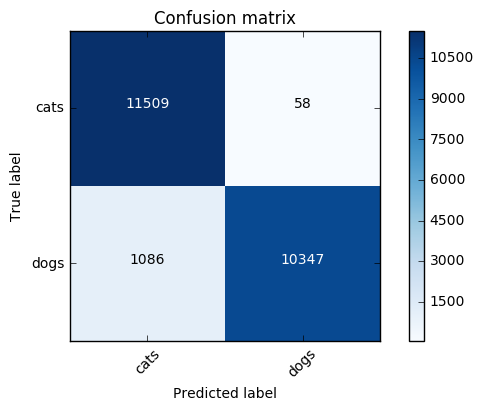

In [102]:
# Jetzt führen wir die Vorhersage mit dem "normalen" Dataset durch:
predict_and_plot_confusion_matrix(vgg, os.path.join('data','train'))